## Day 0 vs Day 30 subject 2
The data used in this notebook is lymphocyte data for subject 2's B cells from 2 time points. We use this data to show the proteome variation between collection times. 

Here, we note presence/absense changes and quantify fold changes using a T test.


In [1]:
import longitudinalCLL
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log10
import pandas as pd
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from gprofiler import GProfiler
import numpy as np
from statistics import mean

### Access data
First, we import our data package. This brings the functions defined there into scope so we can use them in this script. Then we can create a proteomic dataset object and store it as <code>prot</code>. You can select versions and subjects with <code>load_dataset</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [2]:
prot = longitudinalCLL.get_proteomic()
prot.load_dataset(version='July_noMBR_FP', subjects = [2])

prot.data_raw.head()

,Subject2_B_cells_062920_E_11,Subject2_B_cells_062920_E_12,Subject2_B_cells_062920_E_13,Subject2_B_cells_062920_E_16,Subject2_B_cells_062920_E_9,Subject2_B_cells_072920_E_1,Subject2_B_cells_072920_E_2,Subject2_B_cells_072920_E_4,Subject2_B_cells_072920_E_5,Subject2_B_cells_072920_E_7,...,Subject2_T_cells_062920_F_12,Subject2_T_cells_062920_F_13,Subject2_T_cells_062920_F_14,Subject2_T_cells_062920_F_9,Subject2_T_cells_072920_F_1,Subject2_T_cells_072920_F_3,Subject2_T_cells_072920_F_4,Subject2_T_cells_072920_F_5,Subject2_T_cells_072920_F_6,Subject2_T_cells_072920_F_8
Protein ID,,,,,,,,,,,,,,,,,,,,,
A0A0B4J2D5,0.0,0.0,0.0,0.0,4099050.2,4933454.5,4998927.5,5152668.5,2474851.0,4542057.0,...,0.0,4905873.00,0.0,3405266.0,4656720.00,1673629.9,6060600.5,2407679.5,7791855.0,5542659.50
A0AVT1,2085089.5,2154074.2,0.0,2266665.2,0.0,0.0,1019033.0,3165020.8,1684720.6,1906287.2,...,1091121.4,630647.25,576871.9,0.0,0.00,0.0,0.0,827356.1,1260652.0,0.00
A0FGR8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1514363.4,866311.94,0.0,0.0,0.00,0.0,0.0,0.0,653698.6,879074.56
A6NHR9,3540237.5,2421284.0,2306652.0,2554028.8,666470.9,1914117.8,1527918.9,2105808.0,1398487.1,2037837.5,...,0.0,0.00,0.0,0.0,430484.97,0.0,0.0,0.0,538303.6,948190.40
A8K2U0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00


Our next steps will require separating the runs by cell type, to compare June and July. As you see above, the pattern for naming the columns is Subject, B or T cell type, date, and the replicate number. Here we define the list of cell types that the functions should look for based on the naming pattern.

Note that the <code>prot</code> data is only from subject 2, which could also be specified <code>cell_types=['Subject2_B_cells_062920', 'Subject2_B_cells_072920']</code>
This could also be simplified as <code>cell_types=['B_cells_07', 'B_cells_06']</code> as the only requirement is that this string is in all replicates that you want to include and no other samples.

In [3]:
cell_types=['B_cells_072920', 'B_cells_062920']

We can check which proteins are only identified in one cell type. We'll set these aside for now, in the <code>data_in_one_type</code> dataframe. For our analysis, present in more than half, or at least 3 out of 5 replicates, is considered clear although it is interesting to note those proteins identified in all replicates of one type.

In [4]:
present_only_in = prot.check_presence_absence(min_reps=3, cell_types=cell_types, null_value=0).dropna()

print("Proteins identified only in:")
print(present_only_in.value_counts())
data_in_one_type =prot.data_frame.loc[present_only_in.index]
data_in_one_type['Type'] = present_only_in

Proteins identified only in:
B_cells_072920    185
B_cells_062920      8
dtype: int64


The <code>min_reps</code> is the minimum number of replicates required to list a protein as present in one type. This can be changed, i.e., <code>min_reps=5</code> to determine the proteins identified in all 5 replicates of a single type. Be careful not set it to a number greater than the replicates run or no proteins will be returned.

In [5]:
present_5of5_only_in = prot.check_presence_absence(min_reps=5, cell_types=cell_types, null_value=0).dropna()

In [6]:
print("Proteins identified in 5/5 replicates only in:")
print(present_5of5_only_in.value_counts())
data_in_5of5_one_type =prot.data_frame.loc[present_5of5_only_in.index]
data_in_5of5_one_type['Type'] = present_5of5_only_in

Proteins identified in 5/5 replicates only in:
B_cells_072920    90
B_cells_062920     5
dtype: int64


### Filter data 
Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [7]:
indecies = prot.check_n_of_each_type(cell_types=cell_types, null_value=0)
prot.data_frame = prot.data_frame[indecies]

In [8]:
print ("Total groups identified:")
print(prot.data_raw.shape[0])

print ("Proteins identified in at least 3 of each cell type:\t")
print (prot.data_frame.shape[0])

Total groups identified:
2426
Proteins identified in at least 3 of each cell type:	
1135


Before any analysis, we log normalize and median normalize across runs. We need to do this after filtering for consistently expressed proteins so those only identified in some rows do not throw off the normalization.

In [9]:
prot.normalize()

,Subject2_B_cells_062920_E_11,Subject2_B_cells_062920_E_12,Subject2_B_cells_062920_E_13,Subject2_B_cells_062920_E_16,Subject2_B_cells_062920_E_9,Subject2_B_cells_072920_E_1,Subject2_B_cells_072920_E_2,Subject2_B_cells_072920_E_4,Subject2_B_cells_072920_E_5,Subject2_B_cells_072920_E_7,...,Subject2_T_cells_062920_F_12,Subject2_T_cells_062920_F_13,Subject2_T_cells_062920_F_14,Subject2_T_cells_062920_F_9,Subject2_T_cells_072920_F_1,Subject2_T_cells_072920_F_3,Subject2_T_cells_072920_F_4,Subject2_T_cells_072920_F_5,Subject2_T_cells_072920_F_6,Subject2_T_cells_072920_F_8
Protein ID,,,,,,,,,,,,,,,,,,,,,
A0AVT1,-1.527998,-1.561431,NaN,-1.452184,NaN,NaN,-2.465358,-0.893308,-1.835162,-1.739436,...,-2.568679,-3.361549,-3.549985,NaN,NaN,NaN,NaN,-2.874807,-2.256912,NaN
A6NHR9,-0.764262,-1.392726,-1.424490,-1.279980,-3.256592,-1.516467,-1.880991,-1.481149,-2.103805,-1.643162,...,NaN,NaN,NaN,NaN,-3.739504,NaN,NaN,NaN,-3.484590,-2.680249
A8MWD9,-3.559681,-0.818561,-1.058135,NaN,-1.580312,-1.548625,-3.329704,-1.670727,NaN,-1.452554,...,NaN,NaN,NaN,-1.261906,-0.237535,-1.282895,-1.637779,-4.380759,-1.475489,NaN
O00148,1.835712,1.819637,1.819495,1.494635,1.601738,1.235148,1.481961,1.662952,1.551758,1.802674,...,1.449518,1.108128,1.692753,1.409062,1.602150,1.420930,1.340205,1.346073,1.512034,1.440320
O00151,0.738653,0.899835,0.915515,0.991889,0.038411,0.513751,1.104235,0.965626,0.941106,0.911324,...,-0.664246,-1.929102,-1.089269,-1.483741,NaN,-1.315770,-1.222997,-0.721689,-1.723913,-1.149714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8NDC0,NaN,-1.827981,-1.471047,NaN,-1.395796,-1.687640,-1.559382,-0.848960,-1.832415,-1.199482,...,-7.105583,-2.333510,-2.409326,NaN,-1.625236,-1.873024,-1.909248,-2.105315,-1.164081,-1.201873
Q8N131,-1.005917,-0.545279,-1.292698,-0.485246,-0.680382,NaN,-1.533366,NaN,-1.486404,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q9BXT2,-0.632656,NaN,-0.294329,NaN,-0.734254,NaN,-0.851003,-0.089636,-1.053820,-0.821363,...,-0.615356,NaN,-0.515508,NaN,-0.859714,-0.907595,-0.974572,0.082780,-1.100058,0.300496


### Analysis
Now we calulate p values using a ttest. 

In [10]:
#Call ttest function
tstats = prot.ttest_wrapper(cell_types=cell_types)

Here we calculate fold change.

In [11]:
fc_comp = 'log2(30)-log2(0)'
tstats[fc_comp] = prot.get_fold_changes(cell_types=cell_types)

Fold change and p values allow us to create a volcano plot.

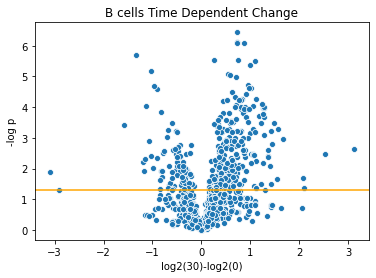

In [12]:
#graph volcano
tstats['-log p'] = -log10(tstats['pvalue'])

figure = sns.scatterplot(x=fc_comp, y='-log p',data=tstats)
figure.set_title("B cells Time Dependent Change")
#plt.axvline(1, color ='orange')
#plt.axvline(-1, color ='orange')
plt.axhline(-log10(.05), color ='orange')
plt.show()

Next we will identify the altered proteins.

In [13]:
altered = prot.is_altered(tstats, pvalue=.05, change_factor=False,
                          change_col=fc_comp, cell_types=cell_types)

In [14]:
tstats.loc[altered.index]

,statistic,pvalue,log2(30)-log2(0),-log p
Protein ID,,,,
O00483,6.594799,0.000100,0.786119,4.000558
O14602,-2.871585,0.018429,-0.807087,1.734497
O14745,3.320670,0.008931,0.608084,2.049111
O15144,2.411379,0.039160,0.411781,1.407153
O15145,3.221717,0.010461,0.450541,1.980445
...,...,...,...,...
Q9ULV4,-3.145611,0.011821,-0.803729,1.927355
Q9Y3U8,5.118892,0.000629,1.104601,3.201407
Q9Y5B9,2.495851,0.034093,0.490842,1.467333


These are significantly altered (p<0.05) without restricting by the magnitude of change:

In [15]:
altered.value_counts()

B_cells_072920    256
B_cells_062920     84
dtype: int64

In [16]:
print("Here are counts for other p and change cutoffs:")
print("P<0.05, >150% of the other type")
print(prot.is_altered(tstats, pvalue=.05,change_factor=1.5,change_col=fc_comp, cell_types=cell_types).value_counts()) #50% increase from either
print("\nP<0.05, >200% of the other type")
print(prot.is_altered(tstats, pvalue=.05,change_factor=2,change_col=fc_comp, cell_types=cell_types).value_counts()) #Double
print("\nP<0.05, >500% of the other type")
print(prot.is_altered(tstats, pvalue=.05,change_factor=5,change_col=fc_comp, cell_types=cell_types).value_counts()) #5 times larger

print("\nP<0.01, >150% of the other type")
print(prot.is_altered(tstats, pvalue=.01,change_factor=1.5,change_col=fc_comp, cell_types=cell_types).value_counts()) #50% increase from either
print("\nP<0.01, >200% of the other type")
print(prot.is_altered(tstats, pvalue=.01,change_factor=2,change_col=fc_comp, cell_types=cell_types).value_counts()) #Double
print("\nP<0.01, >500% of the other type")
print(prot.is_altered(tstats, pvalue=.01,change_factor=5,change_col=fc_comp, cell_types=cell_types).value_counts()) #5 times larger

Here are counts for other p and change cutoffs:
P<0.05, >150% of the other type
B_cells_072920    133
B_cells_062920     31
dtype: int64

P<0.05, >200% of the other type
B_cells_072920    42
B_cells_062920    10
dtype: int64

P<0.05, >500% of the other type
B_cells_072920    2
B_cells_062920    1
dtype: int64

P<0.01, >150% of the other type
B_cells_072920    105
B_cells_062920     19
dtype: int64

P<0.01, >200% of the other type
B_cells_072920    33
B_cells_062920     8
dtype: int64

P<0.01, >500% of the other type
B_cells_072920    2
dtype: int64


### Differentially expressed proteins

Text(0.5, 1.0, 'Day 0 vs Day 30 Subject 2')

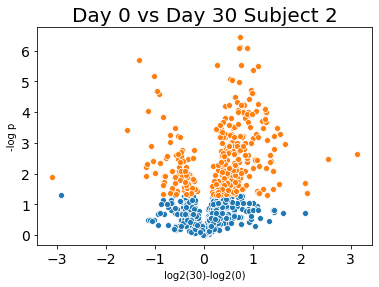

In [17]:
figure = sns.scatterplot(x=fc_comp,y='-log p',data=tstats)
figure2 = sns.scatterplot(x=fc_comp,y='-log p',
                          data=tstats.loc[altered.index])
plt.rc('axes',labelsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Day 0 vs Day 30 Subject 2", fontsize=20)

#plt.savefig("testing/data/0_v_30_2.png", bbox_inches='tight', dpi=300)

This shows the differentially expressed proteins. Recall that this dataset is restricted to those expressed in at least three of each cell type.

The next step is to identify those proteins by name. Here we get the protein names from the fasta file, which remain the same regardless of which software the data was quantified using.


*Note that this function doesn't really have a place in the new set up yet.*

In [18]:
def load_fasta(file="longitudinalCLL/data/uniprot-filtered-proteome_3AUP000005640_reviewed_human.fasta"):
    
    #file is formated:
    #>sp|Q96IY4|CBPB2_HUMAN Carboxypeptidase B2 OS=Homo sapiens OX=9606 GN=CPB2 PE=1 SV=2
    #MKLCS...
    headings = {}
    with open(file) as f:
        for line in f:
            if line.startswith('>'):#header line
                ID = line.split('|')[1]
                name=line.split('|')[2].split('=')[0].strip('OS')
                headings[ID]=name
    headings = pd.Series(list(headings.values()), index=headings.keys())
    
    return headings

In [19]:
protein_names = load_fasta()

In [20]:
protein_names_by_group={}
for ID in prot.data_raw.index:
    if ';' in ID:
        ids = ID.split(';')
        names=''
        for i in ids:
            if i in protein_names.index:
                names=names + protein_names[i] + ';'
        names = names[:-1]
        protein_names_by_group[ID] = names
    else:
        if ID in protein_names.index:
            protein_names_by_group[ID]=protein_names[ID]
protein_names_by_group = pd.Series(list(protein_names_by_group.values()), index=protein_names_by_group.keys())

Here we add the names to the <code>tstats</code> dataframe, which contains the fold changes for each protein. Then we can list the proteins that are altered. Optionally, use <code> head()</code> to display the first few or <code>to_csv</code> to write out to a file. We now split up the proteins heightened in June from those heightened in July.

In [21]:
tstats['Name']=protein_names_by_group
tstats['GeneID'] = tstats.Name.apply(lambda n: str(n).split('_HUMAN')[0])

altered_proteins = tstats.loc[altered.index].sort_values(fc_comp,
                        ascending=False)[['Name','GeneID',fc_comp,'pvalue']]
higher_in_group1 = altered_proteins.loc[altered_proteins[fc_comp] >0]
higher_in_group2 = altered_proteins.loc[altered_proteins[fc_comp] <0]

#To write out to a file, use:
#altered_proteins.to_csv('data/filename.tsv', sep='\t')

Next we do the same for those only identified in one cell type.

In [22]:
data_in_one_type['Name'] = protein_names_by_group
data_in_one_type['GeneID']=data_in_one_type.Name.apply(lambda n: str(n).split('_HUMAN')[0])

group1_only_geneset = data_in_one_type[(data_in_one_type.Type==cell_types[0])]
group2_only_geneset= data_in_one_type[(data_in_one_type.Type==cell_types[1])]

### Proteins Higher in July:

In [23]:
higher_in_group1

,Name,GeneID,log2(30)-log2(0),pvalue
Protein ID,,,,
P02724,GLPA_HUMAN Glycophorin-A,GLPA,3.122357,0.002256
P26368,U2AF2_HUMAN Splicing factor U2AF 65 kDa subunit,U2AF2,2.533367,0.003469
Q9H9B4,FXN1_HUMAN Sideroflexin-1,FXN1,2.098472,0.042205
P67809,YBOX1_HUMAN Y-box-binding protein 1,YBOX1,2.073728,0.020918
P04233,HG2A_HUMAN HLA class II histocompatibility ant...,HG2A,1.659774,0.001127
...,...,...,...,...
Q9Y490,TLN1_HUMAN Talin-1,TLN1,0.195626,0.005746
P55072,TERA_HUMAN Transitional endoplasmic reticulum ...,TERA,0.181269,0.048025
P11171,41_HUMAN Protein 4.1,41,0.160048,0.027341


In [24]:
#sanity check with a couple proteins
#prot.data_frame.loc['P02775']

### Proteins Only in July:

In [25]:
group1_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein ID,,
O00154,BACH_HUMAN Cytosolic acyl coenzyme A thioester...,BACH
O00244,ATOX1_HUMAN Copper transport protein ATOX1,ATOX1
O00273,DFFA_HUMAN DNA fragmentation factor subunit al...,DFFA
O00429,DNM1L_HUMAN Dynamin-1-like protein,DNM1L
O14579,COPE_HUMAN Coatomer subunit epsilon,COPE
...,...,...
Q9Y385,UB2J1_HUMAN Ubiquitin-conjugating enzyme E2 J1,UB2J1
Q9Y547,IFT25_HUMAN Intraflagellar transport protein 2...,IFT25
Q9Y679,AUP1_HUMAN Ancient ubiquitous protein 1,AUP1


### Proteins higher or only in July by GeneID
<code>group1_set</code> is defined here as both the above lists of names, those higher or only in group 1 cells.
Note that this might not be the most interesting set of proteins, ie, when comparing data that was not run together those that appear only in one time are much more likely to be run errors.

In [26]:
group1_set = list(higher_in_group1.GeneID)+list(group1_only_geneset.GeneID)

In [27]:
len(group1_set)

441

### Proteins Higher in June:

In [28]:
higher_in_group2.sort_values('pvalue', ascending=True)

,Name,GeneID,log2(30)-log2(0),pvalue
Protein ID,,,,
Q92522,H1X_HUMAN Histone H1x,H1X,-1.330087,0.000002
P40925,"MDHC_HUMAN Malate dehydrogenase, cytoplasmic",MDHC,-1.025734,0.000007
Q96G03,PGM2_HUMAN Phosphoglucomutase-2,PGM2,-0.967926,0.000020
P09960,LKHA4_HUMAN Leukotriene A-4 hydrolase,LKHA4,-0.911815,0.000026
P98179,RBM3_HUMAN RNA-binding protein 3,RBM3,-1.137013,0.000094
...,...,...,...,...
P63279,UBC9_HUMAN SUMO-conjugating enzyme UBC9,UBC9,-0.570989,0.044678
P05455,LA_HUMAN Lupus La protein,LA,-0.844461,0.046864
P07384,CAN1_HUMAN Calpain-1 catalytic subunit,CAN1,-0.279988,0.047084


### Proteins Only in June:

In [29]:
group2_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein ID,,
O95969,G1D2_HUMAN Secretoglobin family 1D member 2,G1D2
P01833,PIGR_HUMAN Polymeric immunoglobulin receptor,PIGR
P02814,MR3B_HUMAN Submaxillary gland androgen-regulat...,MR3B
P20930,FILA_HUMAN Filaggrin,FILA
P62306,RUXF_HUMAN Small nuclear ribonucleoprotein F,RUXF
Q8TAX7,MUC7_HUMAN Mucin-7,MUC7
Q9UGM3,DMBT1_HUMAN Deleted in malignant brain tumors ...,DMBT1
P02808,TAT_HUMAN Statherin,TAT


### Proteins higher or only in June by GeneID
<code>group2_set</code> is defined here as both the above lists of names, those higher or only in June.

In [30]:
group2_set = list(higher_in_group2.GeneID)+list(group2_only_geneset.GeneID)

In [31]:
len(group2_set)

92

In [32]:
#Check to see that June and July differential sets we compiled are distinct lists
#venn2(subsets = (set(group1_set), set(group2_set)), set_labels = ('July', 'June'))
#plt.savefig('data/diff_overlap_2.png')
#plt.show()

### KEGG pathway enrichment
Here I do a functional pathway enrichment. I use GProfiler to run a KEGG analysis on the differential proteins.
<code>group1_set</code> is proteins differentially expressed in July
<code>group2_set</code> is proteins differentially expressed in June

In [33]:
gp = GProfiler(return_dataframe = True)

In [34]:
group1 = gp.profile(organism='hsapiens', query=list(group1_set))
group1[group1["source"] == "KEGG"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
151,KEGG,KEGG:04144,Endocytosis,0.001295,True,Endocytosis,252,101,13,8000,0.128713,0.051587,query_1,[KEGG:00000]
279,KEGG,KEGG:05012,Parkinson disease,0.024196,True,Parkinson disease,249,101,11,8000,0.108911,0.044177,query_1,[KEGG:00000]
309,KEGG,KEGG:05100,Bacterial invasion of epithelial cells,0.034089,True,Bacterial invasion of epithelial cells,77,101,6,8000,0.059406,0.077922,query_1,[KEGG:00000]


In [35]:
group2 = gp.profile(organism='hsapiens', query=list(group2_set))
group2[group2["source"] == "KEGG"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents


## Suplementary Table: Distinguished Proteins
Here we combine the data from the four categories in one dataframe and output it to a tab-separated file.

First, we get the names of the distinguished proteins.

In [36]:
distinguished_proteins = pd.concat([higher_in_group1, higher_in_group2])

In [37]:
distinguished_proteins

,Name,GeneID,log2(30)-log2(0),pvalue
Protein ID,,,,
P02724,GLPA_HUMAN Glycophorin-A,GLPA,3.122357,0.002256
P26368,U2AF2_HUMAN Splicing factor U2AF 65 kDa subunit,U2AF2,2.533367,0.003469
Q9H9B4,FXN1_HUMAN Sideroflexin-1,FXN1,2.098472,0.042205
P67809,YBOX1_HUMAN Y-box-binding protein 1,YBOX1,2.073728,0.020918
P04233,HG2A_HUMAN HLA class II histocompatibility ant...,HG2A,1.659774,0.001127
...,...,...,...,...
O43399,TPD54_HUMAN Tumor protein D54,TPD54,-1.174742,0.011620
Q07812,BAX_HUMAN Apoptosis regulator BAX,BAX,-1.192345,0.006341
Q92522,H1X_HUMAN Histone H1x,H1X,-1.330087,0.000002


Next, we get the intensity data for these proteins.

In [38]:
altered_data = prot.data_frame.loc[distinguished_proteins.index]

Next, we average by cell type, creating new columns in our <code>distinguished_proteins</code> dataframe.

In [39]:
samples=np.array(prot.data_raw.columns.values)

def mean_noNan(ser):
    ser = ser.dropna()
    if len(ser)==0:
        return np.nan
    return mean(ser)

for cell_type in cell_types:
    cells_of_type = list(s for i,s in enumerate(samples) if cell_type in s)
    type_data = altered_data[cells_of_type]
    means = type_data.apply(mean_noNan, axis=1)
    
    distinguished_proteins[("Mean {0}".format(cell_type))] = means

Here we check the column order and rearrange it as we like.

In [40]:
distinguished_proteins.columns

Index(['Name', 'GeneID', 'log2(30)-log2(0)', 'pvalue', 'Mean B_cells_072920',
       'Mean B_cells_062920'],
      dtype='object')

In [41]:
distinguished_proteins = distinguished_proteins[["GeneID", "Mean B_cells_062920", "Mean B_cells_072920", "log2(30)-log2(0)", "pvalue"]]

Here we sort the proteins. This will sort them such that high abundance in June come first, down it low abundance in June, and finally sorting the July only proteins from low to high.

In [42]:
distinguished_proteins.sort_values(["Mean B_cells_062920", "Mean B_cells_072920"], ascending=[False, False], inplace=True)

<ipython-input-42-850e92c8ccdf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distinguished_proteins.sort_values(["Mean B_cells_062920", "Mean B_cells_072920"], ascending=[False, False], inplace=True)


Finally, we have the finished dataframe.

In [43]:
distinguished_proteins

,GeneID,Mean B_cells_062920,Mean B_cells_072920,log2(30)-log2(0),pvalue
Protein ID,,,,,
P68871,HBB,7.820859,9.089538,1.268678,0.000107
Q8IUE6,H2A2B,7.684598,7.175821,-0.508777,0.005956
P02042,HBD,7.552606,8.612048,1.059443,0.000093
P06899,H2B1J,7.454500,8.259108,0.804608,0.000101
O60814,H2B1K,7.448786,8.322871,0.874085,0.000135
...,...,...,...,...,...
P07948,LYN,-1.990158,-1.419845,0.570313,0.011124
P39748,FEN1,-2.035677,-0.632965,1.402712,0.008024
P33992,MCM5,-2.132670,-1.015408,1.117262,0.005560


The last step is saving this dataframe to a file.

In [44]:
#distinguished_proteins.to_csv('data/distinguished_proteins_Sub1B_Day0_vs30_FP_noMBR.tsv', sep='\t')